# 1. intro
## 1-1. RNN의 한계와 Attention의 등장
### RNN의 한계
- RNN은 이전 데이터를 다음 단계로 전달해야 하기에, 장기 의존성 문제, Vanishing gradient라는 한계점이 존재한다.
    - $X_{t-1}$에 대해 $O_{t-1}$의 출력이 나오고, 이때의 정보 $h_{t-1}$은 다음 시점의 $h_t$로 전달되어 과거 정보가 계속 전달된다.
    - 가중치 공유: 모든 스텝에서 동일한 가중치를 사용한다.
    - Exploding gradient: 초반부가 과도하게 후반부에 반영.
    - Vanishing gradient: 초반부가 후반부에 반영되지 않음.
- LSTM은 기억할 것과 잊을 것을 정하자는 아이디어에서 출발한다.
    - cell state: 가중치를 적용하지 않고 바로 전달되는 정보
    - input gate: 새 정보 중 중요 내용만 cell state로 보낸다.
    - forget gate: 필요 없는 정보를 제거한다.
    - output gate: 이번 output 중 필요 정보만 뽑아낸다.
    - `+` 초반부터 오래 기억 가능, gradient 유지 가능.
    - `-` 시간이 오래 걸린다. 긴 문장에선 vanishing gradient

### Seq2Seq
- input을 다른 sequence로 변환하는 모델
- 입출력의 단어 개수가 달라도 된다. 형태, 내용 등의 변환이 필요한 경우에도 적용할 수 있다.
- Encoder: input에서 Context vector로 원문 특징을 표현한다.
- Decoder: Context vector를 이용해 결과(번역문)를 생성한다.
- Context Vector: encoder의 출력, decoder의 입력, **고정된 크기의 벡터**

### Attention의 등장 배경: seq2seq의 병목 현상
- 고정된 크기의 Context vector를 사용하기 때문에 input의 소실이 발생하는 문제
> Attention은 Decoder가 단어를 생성할 때마다 입력 문장 전체를 다시 확인하여, 가장 관련 있는 정보들을 이용해 새로운 Context vector를 생성한다.
- input sequence에서 어떤 단어에 얼마나 집중할지
- seq2seq와의 가장 큰 차이점은 context vector를 동적으로 계산한다는 점(병렬화)

### Attention Mechanism
1. input을 vector 형태로 변화하여 요소 수치화(vector embedding)
2. 각 요소 별 중요도 점수 산출
    - Score: 유사성을 측정해 관련도
    - Softmax: 중요도를 배분한다(attention weight)
3. 중요도에 따른 입력 정보 조합
    - 특정 정보에 더 집중, 낮은 단어 무시

`+` 시간 경과에 대한 유연성(vs RNN)

- 모든 단어에서 다른 단어로 직접 연결하기 때문에 정보 손실 없이 파악할 수 있다.

`+` 공간에 대한 유연성(vs CNN)

- filter를 이용해 local만 볼 수 있는 CNN에 비해, Attention은 이미지의 모든 픽셀이 다른 픽셀과 직접 연결되기 때문에 global하게 학습할 수 있다.

`+` 병렬화(vs RNN)

- RNN은 순차 계산이 필수라 병렬화할 수 없으나, Attention은 self-attention에서 모든 단어의 관계를 한번에, 독립적으로 계산할 수 있다.

## 1-2. Attention is All You Need
- Transformer 구조(Self-Attention)
- GPT, Gemini, Claude, DeepSeek 등

1. 순차 구조를 제거하고, encoder부터 decoder까지 Attention만 사용하는 모델을 만들어보자.
2. Transformer 등장
3. Recurrence, Convolution이 필수가 아님을 증명하여, 병렬화를 할 수 있게 만들었다!
4. LLM 탄생(BERT, GPT), NLP 평정, Vision Transformer로 확장

### Transformer
- Attention 기반 seq2seq: RNN으로 인코더/디코더 구현 + attention
- transformer: Attention만으로 인코더/디코더까지 구현

> **핵심 기술: Self-Attention, Multi-Head Attention, Positional Encoding**

# 2. Self-Attention
## 2-1. Query, Key, Value
→ 모델이 관련 정보를 효과적으로 찾기 위해 분할
1. Query: 초점의 대상
    - 문장 속 단어와 다른 단어의 관계를 파악하려 할 때, 그 기준이 되는 게 query
2. Key: 검색 대상이 되는 모든 정보들이 달고 있는 색인
    - Q는 K들과 자신을 비교해 관련도를 확인함.
3. Value: K와 묶여 있는 실제 내용물. 
    - Q와 K의 관련도 계산이 끝나고, 가장 높은 K와 그에 해당하는 V를 이용한다.
    - Q가 특정 K와 관련이 깊다 판단되면 K가 가진 V를 가져와 자기를 보강하는 데 사용됨.

## 2-2. 기존 Cross-Attention vs. Self-Attention
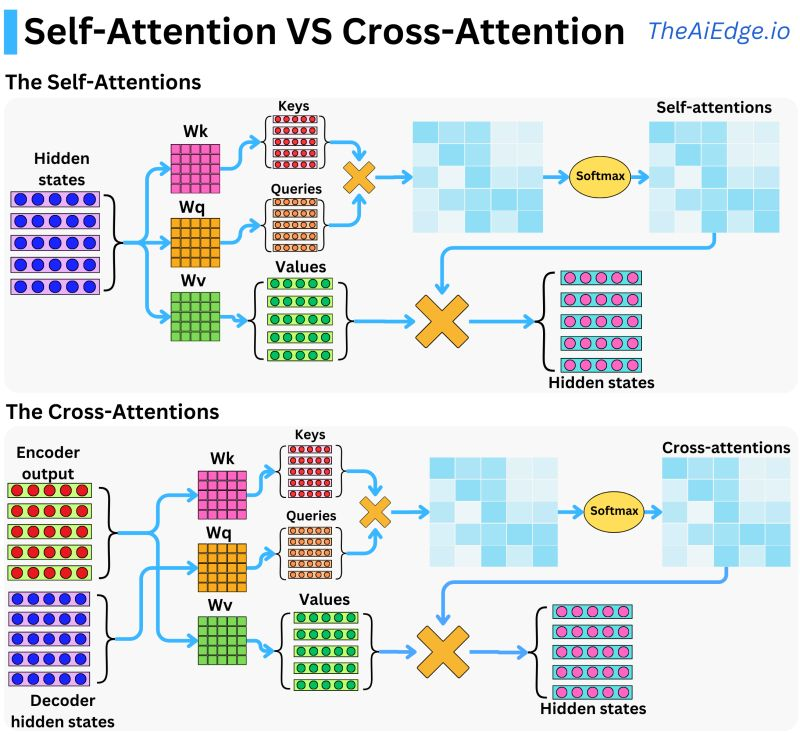

### 기존 Attention in Seq2Seq (Cross-Attention)
- Q와 K-V 쌍이 서로 다른 시퀀스에서 출력됨.
- 하나의 시퀀스가 완전히 다른 시퀀스를 참고하여 정보를 만드는 것
- Decoder가 Encoder를 참고하는 과정

1. Q 만들기
    - 현재의 상태를 하나의 벡터, Query로 요약한다.
2. K, V 불러오기
    - encoder는 input을 처리해 각 단어에 대한 벡터를 가지고 있음.
3. Attention Score 계산
    - Decoder의 Q가 Encoder의 K와 유사도를 계산함.
    - Q · Kᵢ: 내적을 진행하여 이 단어를 얼마나 참고할지 본다. 그 후 softmax를 적용하여 weight로 변환.
4. Weighted Sum
    - Encoder의 V를 가중치로 섞어줌.
    - Decoder가 필요한 정보를 적절히 섞은 하나의 벡터로 만드는 과정
5. Decoder가 다음 단어를 예측
    - Decoder의 정보와 context vector를 합쳐 다음 단어를 예측한다.

### Self-Attention
→ Q와 K-V 쌍이 같은 시퀀스에서 출력됨.
- 문장 스스로가 문맥을 이해하는 과정.

1. Vector Embedding: 단어의 고유 특징을 담은 vector로 변환
2. Attention Score 계산: 단어 벡터끼리 얼마나 관계되었는지. 깊을수록 점수가 높다.
3. 중요도 배분(softmax & attention weight): 특정 단어를 이해하는 데에 다른 단어들이 몇 %씩 중요한가
4. 문맥이 풍부해진 새로운 벡터 생성

## 2-3. Scaled Dot-Product Attention
### Dot-Product Attention
- attention score 계산 방법
- Q, K를 dot product

`-` 벡터 차원이 커질수록 내적 결과가 너무 커지거나 작게 됨

### Scaled Dot-Product Attention
- Transformer의 attention 계산 공식
- 내적 후, 값의 크기를 맞추는 scaling 과정 추가($\sqrt{d_K}$로 나누기). softmax 적용 후 attention weight를 만들고 V에 곱하여 최종 결과.

- Cross-Attention: Context Vector
- Self-Attention: 문맥적인 표현


# 3. Multi-Head Attention
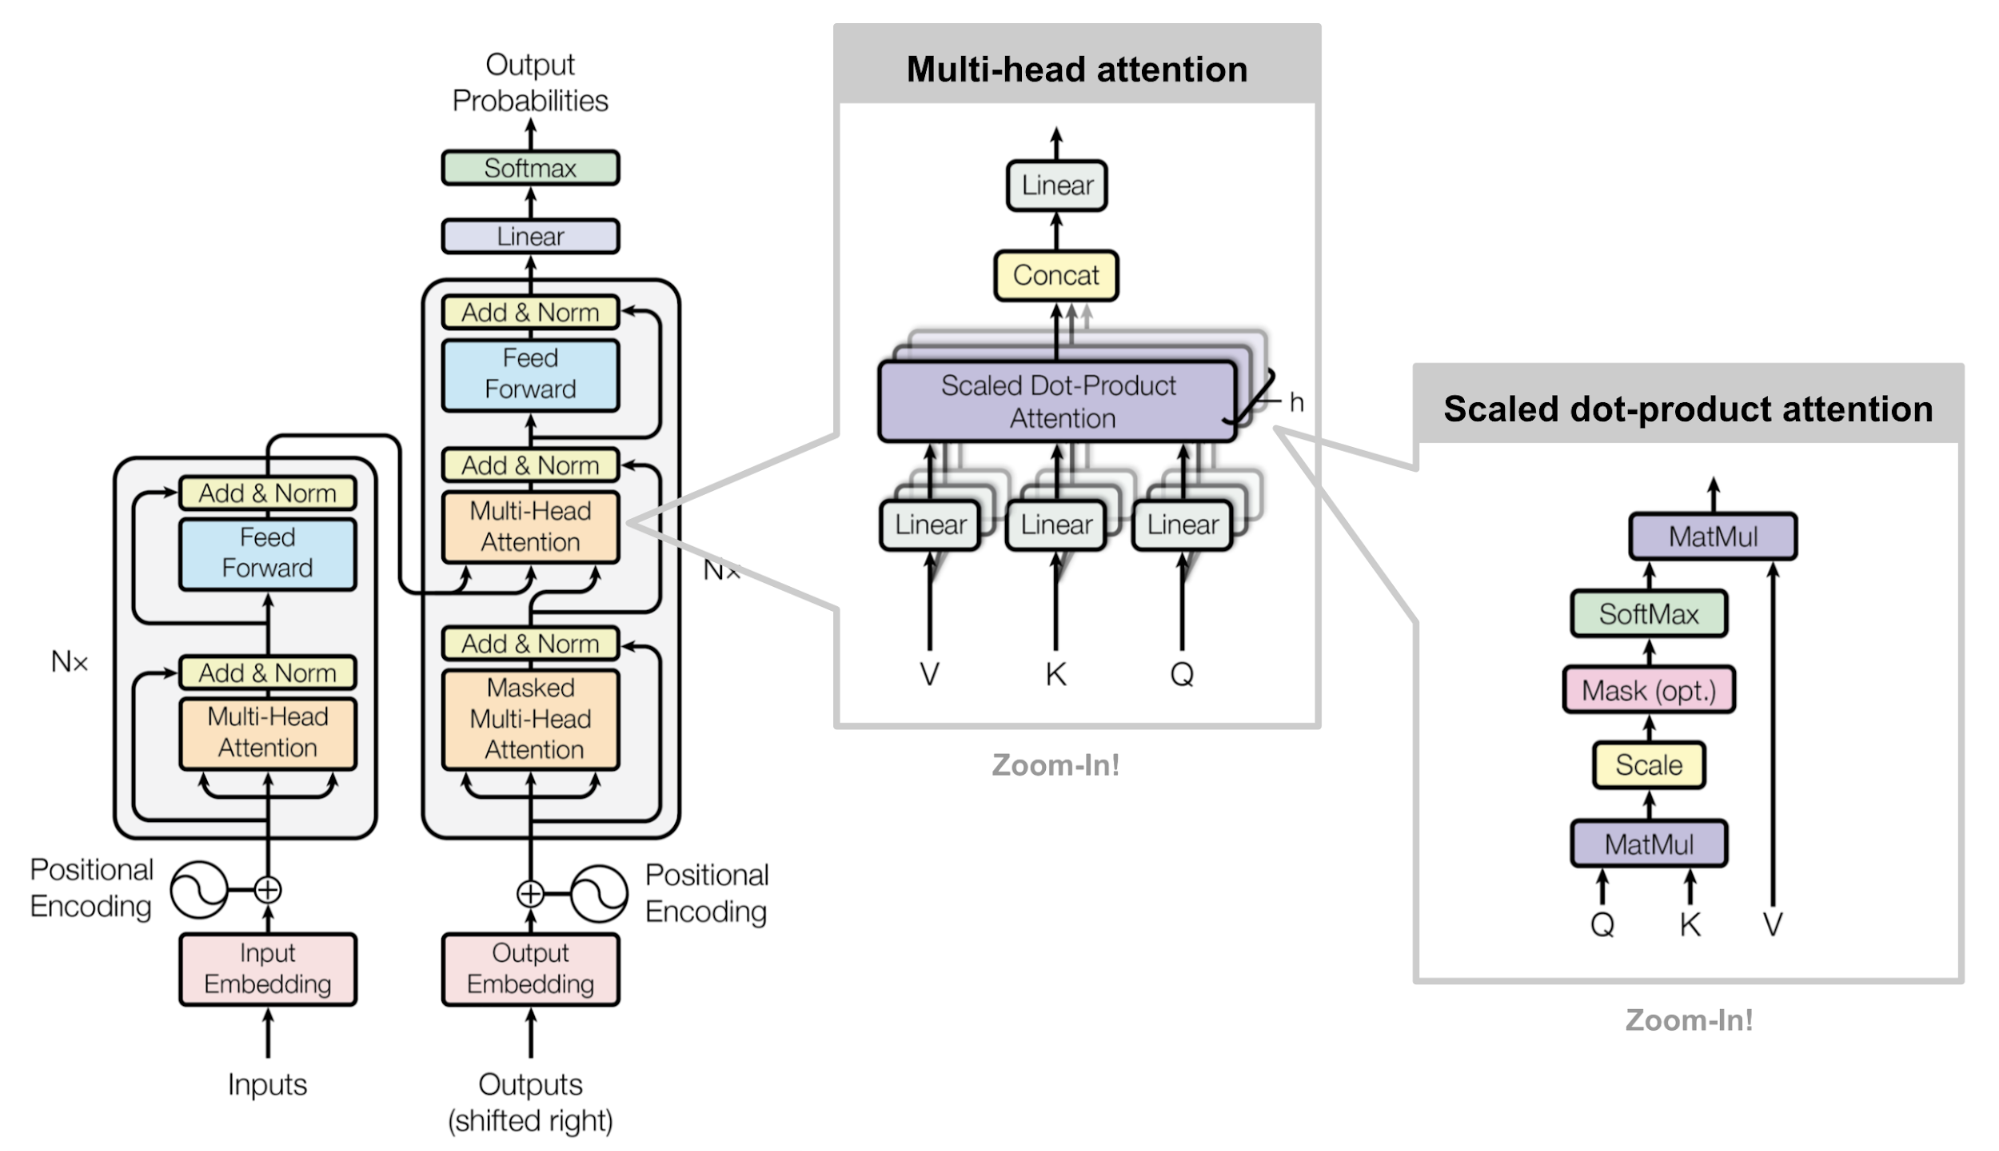
- encoder에서(Masked MHA) 한 번, decoder에서 두 번 적용된다.
- encoding된 토큰들을 아키텍쳐가 이해할 때 사용된다고 보면 된다.

## 3-1. Why Multi-Head Attention?
### Single-Head Attention
- 하나의 가중치 행렬$(W^Q, W^K, W^V)$만 학습
- 모든 종류의 정보를 한 번에 담아 가중 평균 하기 때문에 중요 관계를 놓칠 수 있음.

### Multi-Head Attention
- 한 단어와 다른 단어 간 관계를 여러 차원으로 병렬 학습함.
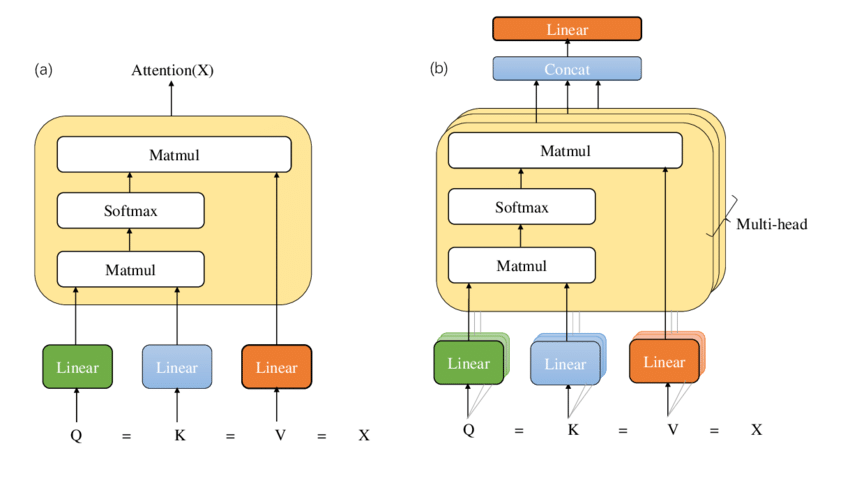

## 3-2. Multi-Head Attention 작동 방식
1. Projection
    - 단어를 나타내는 512차원 벡터가 들어왔을 때, 8개(헤드 수)의 작은 벡터 그룹으로 투영하여 다른 관점으로 나누기. 
2. 병렬 어텐션 계산
    - 각 Head는 서로 간섭하지 않고 병렬로 SDPA(Attention Score, Scale, Softmax, Weighted Sum)를 계산한다. 64차원의 벡터가 나옴.
3. 결합, 최종 투영
    - Concatenate: 각 헤드의 결과를 하나로 합친다.
    - Final Projection: weight matrix를 곱해준다.

# 4. Transformer 아키텍쳐
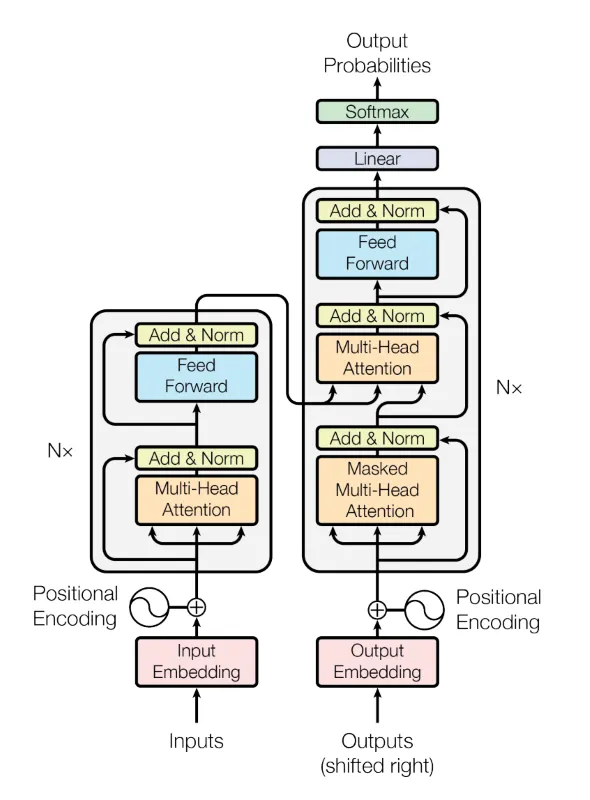

## 4-1. Transformer의 전처리 단계
> inputs, tokenization, embedding, positional encoding

### 1. Tokenization
- input text를 tokens으로 나누기
- 문장 부호도 별도의 토큰을 가짐.

### 2. Embedding
- token은 숫자 벡터로 변환된다.
- 단어의 의미를 공간적으로 표현하는 것: 단어에 대한 기본적인 속성을 제공할 수 있다.
- Word2Vec: 신경망 훈련, 속성 포착, 벡터 추출, 심층 속성 포착

### 3. Positional Encoding
- 단어들의 순서 정보를 embedding vector에 추가하는 단계
- 병렬 처리로 순서를 알지 못하기 때문에, 순서 정보를 제공하기 위해 사용
- 각 단어의 임베딩 좌표에 consistent sequence를 추가하여 순서 기록!!
- 위치에 따라 정해진 동일한 벡터를 적용한다(sin, cos 기반)!! 그래야 순서를 의미할 수 있다. 늘 다른 벡터를 적용하면 순서를 의미할 수 없다.

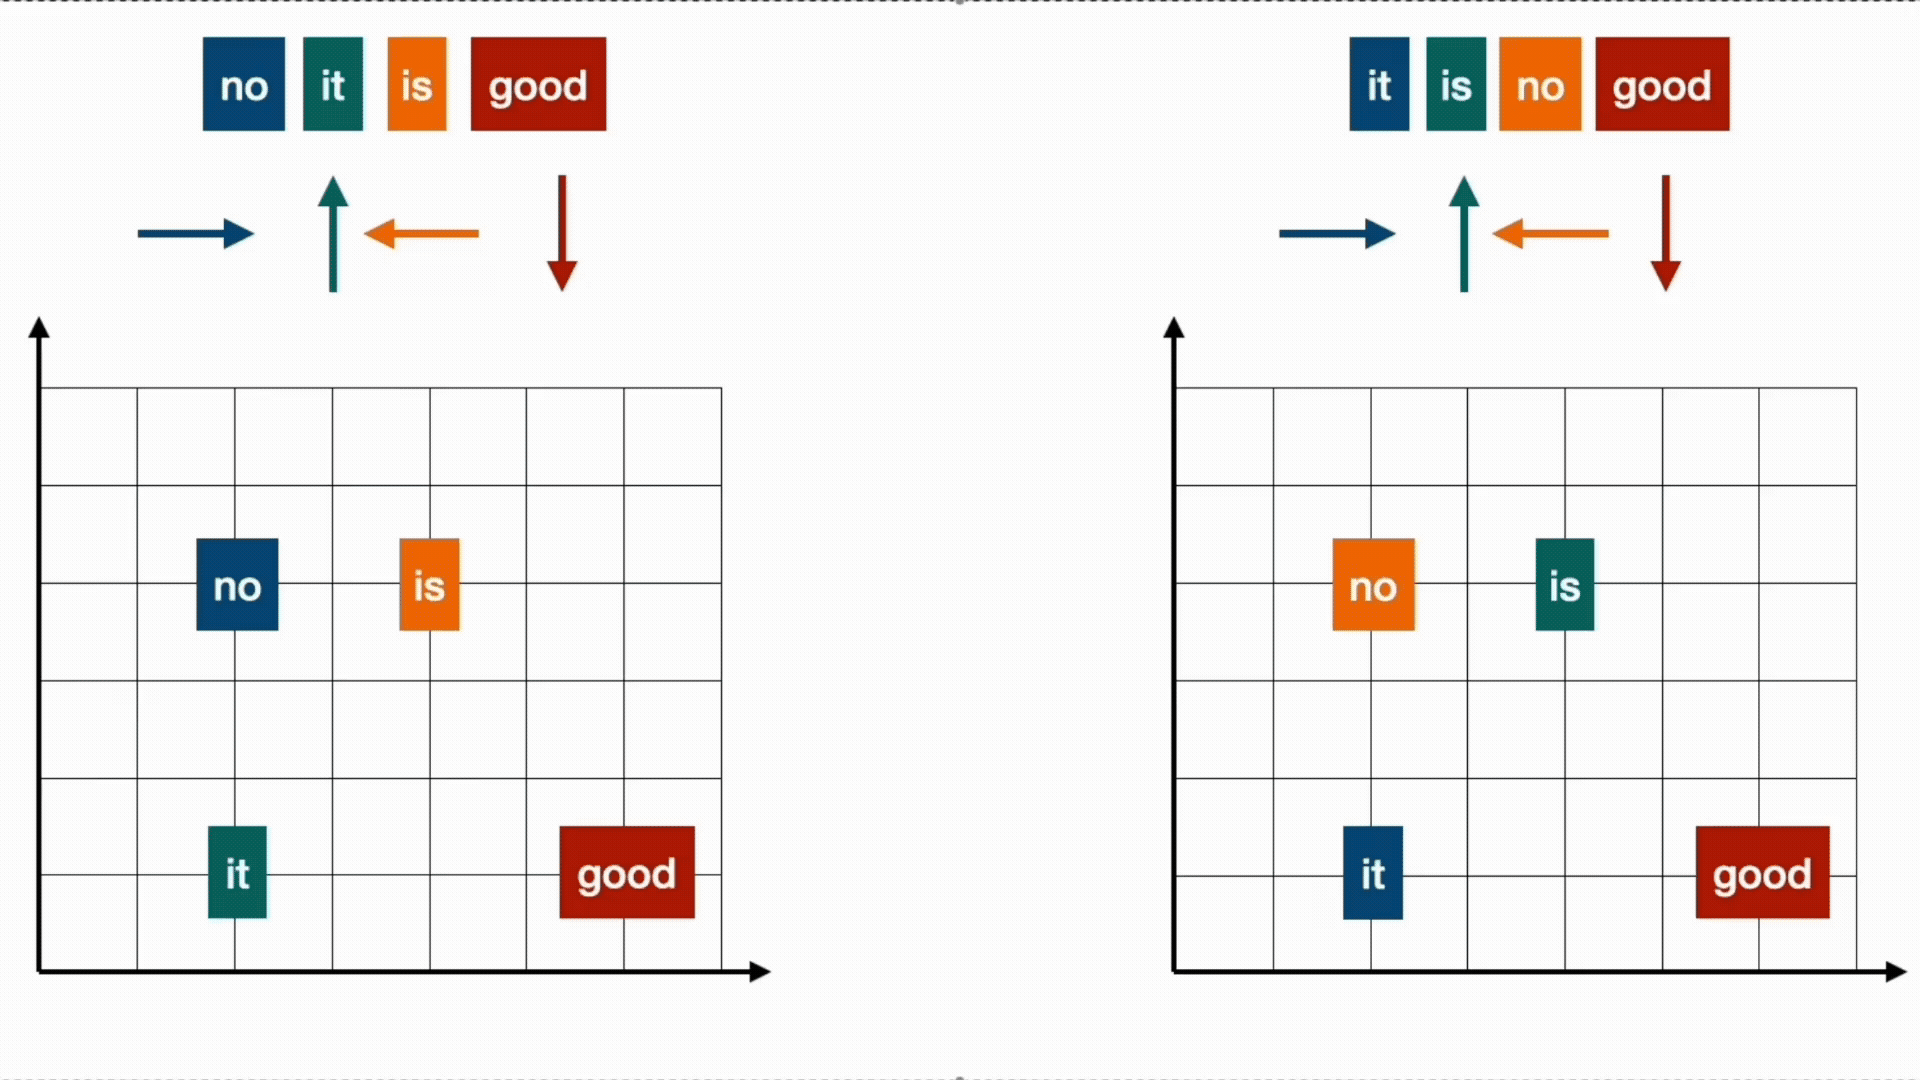

## 4-2. 트랜스포머의 Encoder와 Decoder

### 1. Encoder
- 입력 문장 이해, context vector로 변환
- tokenization, embedding, positional encoding, MHA, FFL로 구성됨


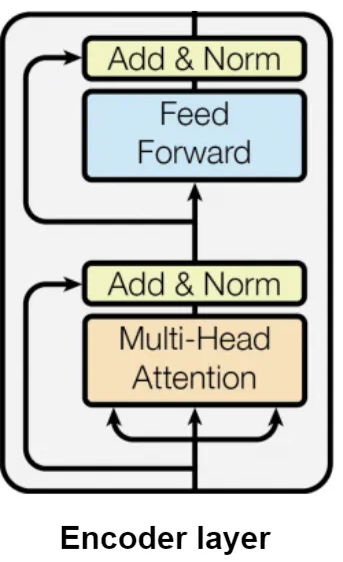

#### (1) Feed-Forward Layer(FFN)
- 입력 벡터 차원 확장 + 비선형 변환 적용
- 특정 단어에 대한 심층 분석

#### (1)-2 Residual connections
- CNN의 ResNet에서 사용한 방법
- output에 input을 전달해주는 것. layer가 많이 쌓여도 학습이 잘되게 함.

#### (2) Layer Normalization
- input의 평균과 분산을 사용해서 정규화: 학습 안정화

### 2. Decoder
- encoder가 분석한 context vector를 받아 output을 순차 생성하는 역할을 담당함.

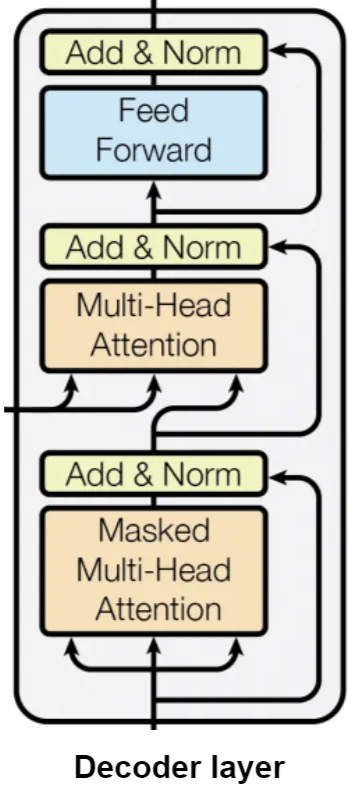

#### (1) Masked Multi-Head Attention
- 미래 단어를 참고하지 못하도록 mask 하기
- 과거 정보만을 기반으로 다음 단어를 예측하도록 강제함.
- Look Ahead Mask를 사용해 오른쪽 token의 attention값을 0으로 만들어 무시하게 한다.

#### (2) Encoder-Decoder Multi-Head Attention(Cross-Attention)
- decoder가 context를 참고하여 현재 생성 중인 단어와 연결하는 과정
- decoder가 입력 문장 중 어떤 부분에 주목해야 하는지 학습

#### (3) Feed-Forward Layer

## 4-3. 전체 모델 및 데이터 흐름

1. 입력 준비: 문장을 (의미 + 위치) 벡터로 바꾸기
    - Embedding, positional encoding
2. Encoder: 입력 문장의 (문맥적 의미) 깊이 이해하기
    - Self-attention을 이용해 모든 단어 간 관계 파악
    - Attention Score, weighted sum, MHA
3. Decoder: 번역 문장을 한 단어씩 생성